# Lab assignment №2: Gradient boosting and feature importance estimation

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

Here we will work with widely known Human Actividy Recognition (HAR) dataset. Data is available at [UCI repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones). Download it and place in `data/` folder in the same directory as this notebook. There are available both raw and preprocessed datasets. This time we will use the preprocessed one.

There are several great frameworks (listed below). However, we recommend to stick to `LightGBM` for this task.
* LightGBM by Microsoft. [Link to github](https://github.com/Microsoft/LightGBM). It is one of the most popular frameworks these days that shows both great quality and performance.
* xgboost by dlmc. [Link to github](https://github.com/dmlc/xgboost). The most famous framework which got very popular on kaggle.
* Catboost by Yandex. [Link to github](https://github.com/catboost/catboost). Novel framework by Yandex company tuned to deal well with categorical features.

Some simple preprocessing is done for you. 

Parts 1 and 3 have the same weight equal to $1$. Part 2 has weight $0.5$.

### Part 1:
Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset:

* $\geq 90\%$ accuracy: 0.5 points for this part
* $\geq 92\%$ accuracy: 0.7 points for this part
* $\geq 94\%$ accuracy: 1 point for this part

In [1]:
from copy import (
    copy,
    deepcopy
)
import operator
import pprint
from typing import (
    Any,
    Dict,
    List,
)

import numpy as np
import pandas as pd
import scipy.stats as sps

try:
    import shap
except ModuleNotFoundError:
    !pip3 install shap
    import shap
    
from sklearn.base import (
    clone,
    BaseEstimator, 
    ClassifierMixin,
)
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import (
    accuracy_score,
    f1_score, 
    precision_score, 
    recall_score,
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

try:
    from catboost import Pool, CatBoostClassifier
except ModuleNotFoundError:
    !pip3 install catboost
    from catboost import Pool, CatBoostClassifier

import matplotlib.pyplot as plt
import plotly.graph_objects as go
try:
    import scikitplot as skplt
except ModuleNotFoundError:
    !pip3 install scikit-plot
    import scikitplot as skplt

from plotly.subplots import make_subplots

In [2]:
X_train = np.genfromtxt('data/train/X_train.txt')
y_train = np.genfromtxt('data/train/y_train.txt')
y_train -= np.full((len(y_train), ), 1) # needs -1 for Catboost

X_test = np.genfromtxt('data/test/X_test.txt')
y_test = np.genfromtxt('data/test/y_test.txt')
y_test -= np.full((len(y_test), ), 1) # needs -1 for Catboost

with open('data/activity_labels.txt', 'r') as iofile:
    activity_labels = iofile.readlines()

activity_labels = [x.replace('\n', '').split(' ') for x in activity_labels]
activity_labels = dict([(int(x[0])-1, x[1]) for x in activity_labels])

In [3]:
pprint.pprint(activity_labels, indent=4)

{   0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING'}


In [4]:
print(X_train.shape)

(7352, 561)


The dataset has some duplicating features. File `unique_columns.txt` stores the indices of the unique ones. 

In [5]:
try: 
    unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)
except OSError:
    ! wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/basic_s20/homeworks_basic/Lab2_boosting/unique_columns.txt -nc
    unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)

X_train = X_train[:, unique_columns]
X_test = X_test[:, unique_columns]

PCA could be useful in this case. E.g.

In [6]:
pca = PCA(0.99)

In [7]:
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [8]:
X_train_pca.shape

(7352, 157)

In [9]:
X_test_pca.shape

(2947, 157)

Text(0, 0.5, 'Principal component 2')

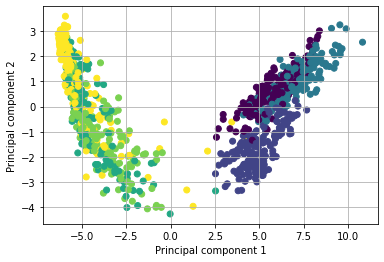

In [10]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

Text(0, 0.5, 'Principal component 5')

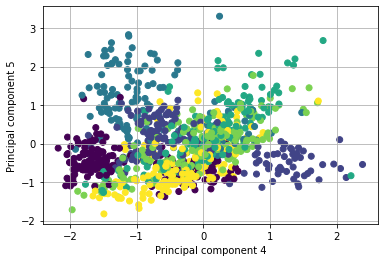

In [11]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 4')
plt.ylabel('Principal component 5')

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to use grid/random search (or any other approach) to approximate them by yourself.

Please try at least several models of different structure.

Provide the following to describe your path:

* Plot describing the model accuracy/precision/recall w.r.t. model complexity.
* ROC-AUC plot for the 3 best models you aquired (for multiclass case you might refer to the `scikit-plot` library.
* Small report describing your experiments.

[DART](https://arxiv.org/abs/1505.01866) might be useful as well in your experiments. It is available in [xgboost](https://xgboost.readthedocs.io/en/latest/tutorials/dart.html) and [LightGBM](https://lightgbm.readthedocs.io/en/latest/Parameters.html), but seems [missing in CatBoost](https://github.com/catboost/catboost/issues/1006).

__Without the report and plots maximum score for this part of the lab is 0.3 of its full weight.__

So, we have 6 classes in our dataset. To begin with, we start the baseline with `LogisticRegression`. Next, we try `SVM` with different kernels and `RandomForest`. Finally, `Catboost` will be used! 

The model's accuracy/precision/recall w.r.t. model complexity will be investigated for `Catboost` and `RandomForest`.

The function `investigate_model` below helps to build plot, find the best estimator and best params.

In [12]:
def extract_params(estimator: Pipeline, clf_key: str="classifier") -> dict:
    clf_idx = list(map(operator.itemgetter(0), estimator.steps)).index(clf_key)
    return estimator.steps[clf_idx][1].get_params()

In [13]:
def investigate_model(
    estimator: Pipeline,
    param_grid: dict,
    verbose: int=10,  
    n_jobs: int=-2
) -> Pipeline:
    search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        verbose=verbose,
        n_jobs=n_jobs
    )
    model = search.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    print(classification_report(y_test, y_pred))
    y_probas = model.predict_proba(X_test_pca)
    skplt.metrics.plot_roc(
        y_test,
        y_probas,
        figsize=(12, 8)
    )
    skplt.metrics.plot_precision_recall(
        y_test, 
        y_probas,
        figsize=(12, 8)
    )
    plt.show()
    return model.best_estimator_

---

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96       496
         1.0       0.98      0.93      0.96       471
         2.0       0.99      0.97      0.98       420
         3.0       0.96      0.88      0.92       491
         4.0       0.86      0.97      0.91       532
         5.0       1.00      0.95      0.98       537

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



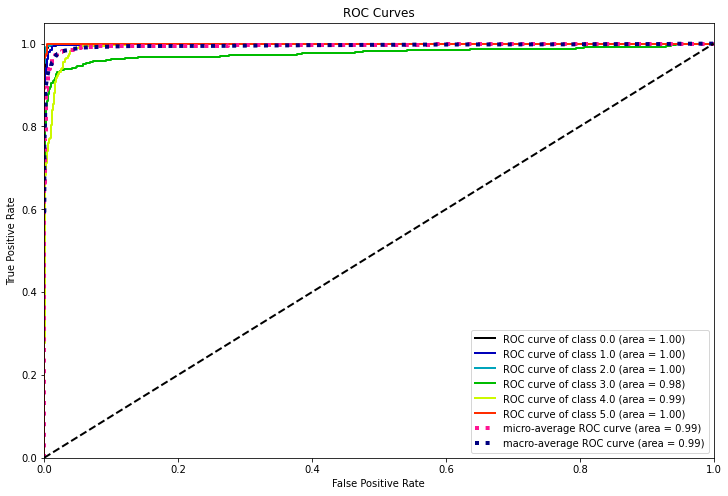

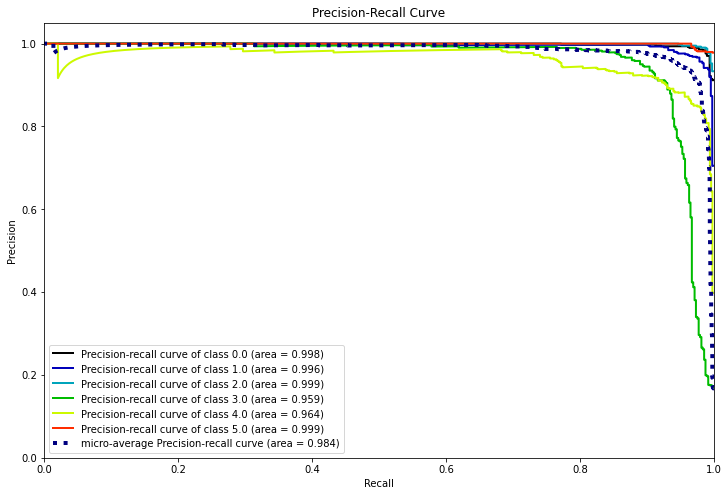

CPU times: user 2.56 s, sys: 389 ms, total: 2.95 s
Wall time: 20.7 s


In [14]:
%%time
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        max_iter=10**2,
        solver='saga',
        tol=1e-2,
        multi_class='multinomial')
    )
])

lr_param_grid={
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2']  
}

lr_best_estimator = investigate_model(
    lr_pipeline, 
    lr_param_grid,
    verbose=0
)

---

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97       496
         1.0       0.97      0.95      0.96       471
         2.0       1.00      0.96      0.98       420
         3.0       0.97      0.88      0.92       491
         4.0       0.90      0.97      0.93       532
         5.0       1.00      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



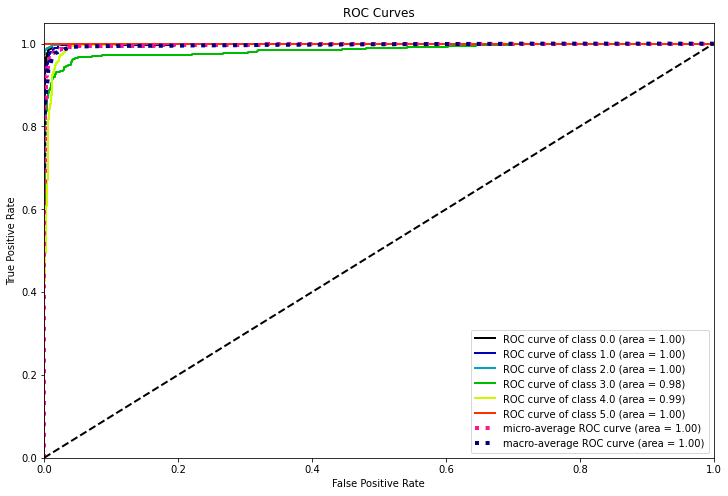

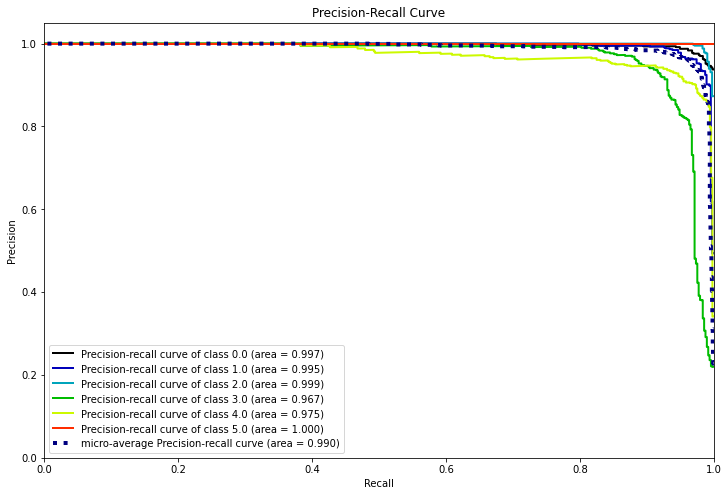

CPU times: user 19.2 s, sys: 44.8 ms, total: 19.3 s
Wall time: 3min 43s


In [15]:
%%time
svm_linear_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(probability=True, kernel='linear'))
])

svm_linear_param_grid={
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
}

svm_linear_best_estimator = investigate_model(
    svm_linear_pipeline, 
    svm_linear_param_grid,
    verbose=0
)

---

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       496
         1.0       1.00      0.94      0.97       471
         2.0       0.86      0.99      0.92       420
         3.0       0.97      0.90      0.93       491
         4.0       0.93      0.97      0.95       532
         5.0       0.99      0.95      0.97       537

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



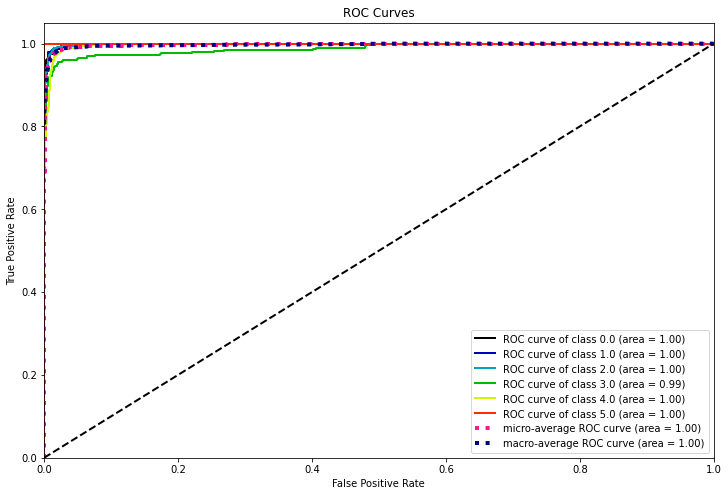

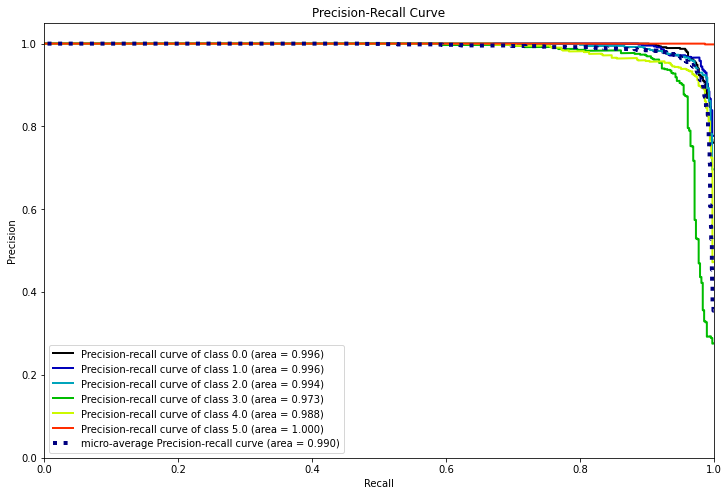

CPU times: user 1min 2s, sys: 93.6 ms, total: 1min 2s
Wall time: 12min


In [16]:
%%time
svm_rbf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(probability=True, kernel='rbf'))
])

svm_rbf_param_grid={
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
}

svm_rbf_best_estimator = investigate_model(
    svm_rbf_pipeline, 
    svm_rbf_param_grid,
    verbose=0,
    n_jobs=-1
)

---

              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92       496
         1.0       0.92      0.93      0.93       471
         2.0       0.92      0.79      0.85       420
         3.0       0.93      0.81      0.87       491
         4.0       0.85      0.95      0.90       532
         5.0       0.99      1.00      1.00       537

    accuracy                           0.91      2947
   macro avg       0.92      0.91      0.91      2947
weighted avg       0.92      0.91      0.91      2947



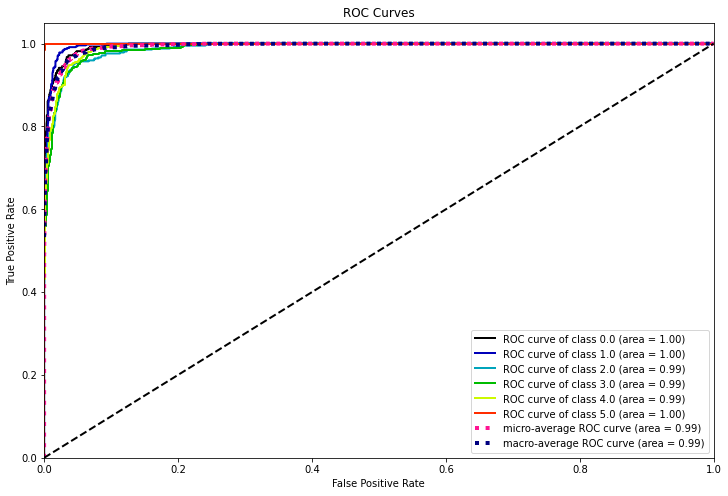

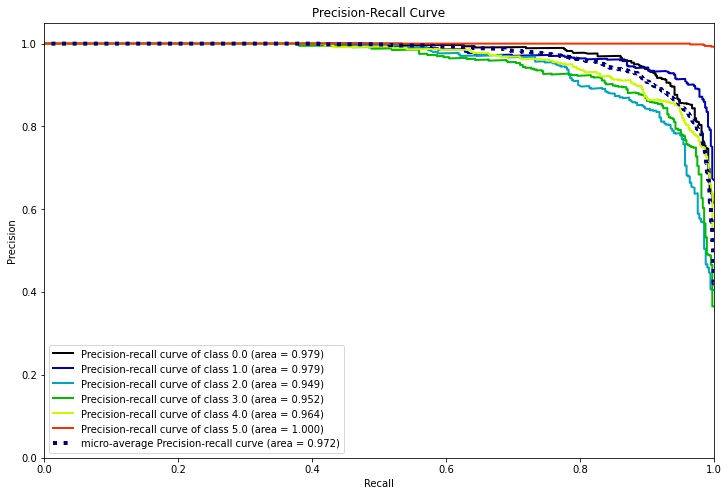

CPU times: user 34.4 s, sys: 32.7 ms, total: 34.5 s
Wall time: 7min 53s


In [17]:
%%time
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=128))
])

rf_param_grid={
    'classifier__criterion' : ['gini', 'entropy'],
    'classifier__max_depth' : np.arange(4, 20, 4),
    'classifier__min_samples_split' : [2, 4, 6]
}

rf_best_estimator = investigate_model(
    rf_pipeline, 
    rf_param_grid,
    verbose=0,
    n_jobs=-1
)

---

As we can see, `LogisticRegression` and `SVM`s have the best accuracy.

`RandomForest` complexity criterias:  


*   maximum depth
*   number of trees
*   stop criterias
*   max features

Apparently, `maximum depth` and `number of trees` affect the most, so let describe the model `accuracy`/`precision`/`recall` w.r.t. them.




In [18]:
def plot_complexity_metrics(
    model_cls: object, 
    model_params: dict,
    grid_model_params: tuple,
    n_jobs: int=-2 
) -> None:
    if n_jobs:
        model_params['n_jobs'] = n_jobs
    accuracy_sc, precision_sc, recall_sc = [], [], []
    param_name, param_grid = grid_model_params
    for param_val in param_grid:
        model_params[param_name] = param_val
        model = model_cls(**model_params)
        model.fit(X_train_pca, y_train)
        accuracy_sc.append(accuracy_score(y_test, model.predict(X_test_pca)))
        precision_sc.append(precision_score(y_test, model.predict(X_test_pca), average='macro'))
        recall_sc.append(recall_score(y_test, model.predict(X_test_pca), average='macro'))
    plt.style.use('ggplot')
    plt.figure(figsize=(12, 9))
    plt.plot(param_grid, accuracy_sc, label='accuracy')
    plt.plot(param_grid, precision_sc, label='precision')
    plt.plot(param_grid, recall_sc, label='recall')
    plt.xlabel(param_name)
    plt.ylabel('Metrics')
    plt.title(f"Metrics' metrics dependence with {param_name}")
    plt.legend()
    plt.show()

In [19]:
plot_complexity_metrics(
    model_cls=RandomForestClassifier,
    model_params=copy(extract_params(rf_best_estimator)),
    grid_model_params=('n_estimators', np.arange(10, 200, 10))
)

As you can see, there is no significant increase in metrics starting from ~110 estimators. 

In [20]:
plot_complexity_metrics(
    model_cls=RandomForestClassifier,
    model_params=copy(extract_params(rf_best_estimator)),
    grid_model_params=('max_depth', np.arange(3, 20, 2))
)

The trees are untrained with small `max_depth` value. The metrics increase with bigger `max_depth`. Simultaneously too big `max_depth` turns ensembles overtrained. As the result, the metrics will decrease. 

---

The time for boosting is coming!

In [21]:
%%time
catboost_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', CatBoostClassifier(
        loss_function='MultiClass',
        classes_count=6,
        learning_rate=0.1,
        l2_leaf_reg=1,
        task_type='CPU',
        eval_metric='Accuracy',
    ))
])

catboost_param_grid={
    'classifier__depth': [4, 5, 6],
    'classifier__iterations': [100, 300, 500]
}

catboost_best_estimator = investigate_model(
    catboost_pipeline, 
    catboost_param_grid,
    verbose=0,
    n_jobs=-1
)

0:	learn: 0.7721708	total: 210ms	remaining: 1m 44s
1:	learn: 0.8106638	total: 373ms	remaining: 1m 32s
2:	learn: 0.8273939	total: 556ms	remaining: 1m 32s
3:	learn: 0.8306583	total: 757ms	remaining: 1m 33s
4:	learn: 0.8328346	total: 946ms	remaining: 1m 33s
5:	learn: 0.8452122	total: 1.1s	remaining: 1m 30s
6:	learn: 0.8479325	total: 1.28s	remaining: 1m 30s
7:	learn: 0.8498368	total: 1.44s	remaining: 1m 28s
8:	learn: 0.8509249	total: 1.66s	remaining: 1m 30s
9:	learn: 0.8544614	total: 1.83s	remaining: 1m 29s
10:	learn: 0.8594940	total: 2.02s	remaining: 1m 29s
11:	learn: 0.8616703	total: 2.17s	remaining: 1m 28s
12:	learn: 0.8658868	total: 2.37s	remaining: 1m 28s
13:	learn: 0.8701034	total: 2.52s	remaining: 1m 27s
14:	learn: 0.8715996	total: 2.7s	remaining: 1m 27s
15:	learn: 0.8752720	total: 2.86s	remaining: 1m 26s
16:	learn: 0.8781284	total: 3.05s	remaining: 1m 26s
17:	learn: 0.8786725	total: 3.21s	remaining: 1m 25s
18:	learn: 0.8805767	total: 3.39s	remaining: 1m 25s
19:	learn: 0.8854733	tot

159:	learn: 0.9948313	total: 27.1s	remaining: 57.7s
160:	learn: 0.9949674	total: 27.3s	remaining: 57.5s
161:	learn: 0.9952394	total: 27.5s	remaining: 57.3s
162:	learn: 0.9952394	total: 27.6s	remaining: 57.1s
163:	learn: 0.9953754	total: 27.8s	remaining: 56.9s
164:	learn: 0.9955114	total: 27.9s	remaining: 56.7s
165:	learn: 0.9955114	total: 28.1s	remaining: 56.6s
166:	learn: 0.9952394	total: 28.3s	remaining: 56.3s
167:	learn: 0.9953754	total: 28.4s	remaining: 56.2s
168:	learn: 0.9956474	total: 28.6s	remaining: 56s
169:	learn: 0.9959195	total: 28.8s	remaining: 55.8s
170:	learn: 0.9960555	total: 28.9s	remaining: 55.6s
171:	learn: 0.9960555	total: 29.1s	remaining: 55.5s
172:	learn: 0.9961915	total: 29.2s	remaining: 55.2s
173:	learn: 0.9960555	total: 29.4s	remaining: 55.1s
174:	learn: 0.9963275	total: 29.5s	remaining: 54.8s
175:	learn: 0.9964635	total: 29.7s	remaining: 54.7s
176:	learn: 0.9964635	total: 29.9s	remaining: 54.5s
177:	learn: 0.9967356	total: 30s	remaining: 54.3s
178:	learn: 0.99

318:	learn: 1.0000000	total: 53.7s	remaining: 30.4s
319:	learn: 1.0000000	total: 53.8s	remaining: 30.3s
320:	learn: 1.0000000	total: 54s	remaining: 30.1s
321:	learn: 1.0000000	total: 54.1s	remaining: 29.9s
322:	learn: 1.0000000	total: 54.3s	remaining: 29.8s
323:	learn: 1.0000000	total: 54.5s	remaining: 29.6s
324:	learn: 1.0000000	total: 54.6s	remaining: 29.4s
325:	learn: 1.0000000	total: 54.8s	remaining: 29.2s
326:	learn: 1.0000000	total: 55s	remaining: 29.1s
327:	learn: 1.0000000	total: 55.1s	remaining: 28.9s
328:	learn: 1.0000000	total: 55.3s	remaining: 28.8s
329:	learn: 1.0000000	total: 55.5s	remaining: 28.6s
330:	learn: 1.0000000	total: 55.7s	remaining: 28.4s
331:	learn: 1.0000000	total: 55.8s	remaining: 28.2s
332:	learn: 1.0000000	total: 56s	remaining: 28.1s
333:	learn: 1.0000000	total: 56.2s	remaining: 27.9s
334:	learn: 1.0000000	total: 56.4s	remaining: 27.8s
335:	learn: 1.0000000	total: 56.5s	remaining: 27.6s
336:	learn: 1.0000000	total: 56.7s	remaining: 27.4s
337:	learn: 1.0000

477:	learn: 1.0000000	total: 1m 19s	remaining: 3.66s
478:	learn: 1.0000000	total: 1m 19s	remaining: 3.5s
479:	learn: 1.0000000	total: 1m 19s	remaining: 3.33s
480:	learn: 1.0000000	total: 1m 20s	remaining: 3.16s
481:	learn: 1.0000000	total: 1m 20s	remaining: 3s
482:	learn: 1.0000000	total: 1m 20s	remaining: 2.83s
483:	learn: 1.0000000	total: 1m 20s	remaining: 2.66s
484:	learn: 1.0000000	total: 1m 20s	remaining: 2.5s
485:	learn: 1.0000000	total: 1m 20s	remaining: 2.33s
486:	learn: 1.0000000	total: 1m 21s	remaining: 2.16s
487:	learn: 1.0000000	total: 1m 21s	remaining: 2s
488:	learn: 1.0000000	total: 1m 21s	remaining: 1.83s
489:	learn: 1.0000000	total: 1m 21s	remaining: 1.66s
490:	learn: 1.0000000	total: 1m 21s	remaining: 1.5s
491:	learn: 1.0000000	total: 1m 21s	remaining: 1.33s
492:	learn: 1.0000000	total: 1m 21s	remaining: 1.16s
493:	learn: 1.0000000	total: 1m 22s	remaining: 998ms
494:	learn: 1.0000000	total: 1m 22s	remaining: 831ms
495:	learn: 1.0000000	total: 1m 22s	remaining: 665ms
49

CPU times: user 4min 58s, sys: 5.45 s, total: 5min 3s
Wall time: 22min 38s


Now, let describe `Catboost` model accuracy/precision/recall w.r.t. `depth` & `iterations`.

In [22]:
plot_complexity_metrics(
    model_cls=CatBoostClassifier,
    model_params=copy(extract_params(catboost_best_estimator)),
    grid_model_params=('depth', np.arange(1, 7, 1)),
    n_jobs=None
)

0:	learn: 0.3755441	total: 7.23ms	remaining: 3.61s
1:	learn: 0.5420294	total: 13.3ms	remaining: 3.3s
2:	learn: 0.5420294	total: 19.1ms	remaining: 3.17s
3:	learn: 0.5420294	total: 28.6ms	remaining: 3.54s
4:	learn: 0.5420294	total: 34.5ms	remaining: 3.41s
5:	learn: 0.5420294	total: 42ms	remaining: 3.46s
6:	learn: 0.5420294	total: 47.9ms	remaining: 3.37s
7:	learn: 0.5412133	total: 54ms	remaining: 3.32s
8:	learn: 0.5412133	total: 61.5ms	remaining: 3.35s
9:	learn: 0.5420294	total: 67.6ms	remaining: 3.31s
10:	learn: 0.5412133	total: 74ms	remaining: 3.29s
11:	learn: 0.5633841	total: 80ms	remaining: 3.25s
12:	learn: 0.6342492	total: 86.9ms	remaining: 3.25s
13:	learn: 0.6373776	total: 99.4ms	remaining: 3.45s
14:	learn: 0.6479869	total: 108ms	remaining: 3.49s
15:	learn: 0.6482590	total: 125ms	remaining: 3.79s
16:	learn: 0.6482590	total: 141ms	remaining: 4.01s
17:	learn: 0.6637650	total: 158ms	remaining: 4.24s
18:	learn: 0.6550598	total: 169ms	remaining: 4.28s
19:	learn: 0.6572361	total: 178ms	re

164:	learn: 0.8975789	total: 1.82s	remaining: 3.69s
165:	learn: 0.8977149	total: 1.83s	remaining: 3.68s
166:	learn: 0.8967628	total: 1.84s	remaining: 3.66s
167:	learn: 0.8978509	total: 1.84s	remaining: 3.65s
168:	learn: 0.8979869	total: 1.85s	remaining: 3.63s
169:	learn: 0.8979869	total: 1.86s	remaining: 3.62s
170:	learn: 0.8982590	total: 1.87s	remaining: 3.6s
171:	learn: 0.8982590	total: 1.88s	remaining: 3.59s
172:	learn: 0.8979869	total: 1.89s	remaining: 3.57s
173:	learn: 0.8983950	total: 1.9s	remaining: 3.56s
174:	learn: 0.8983950	total: 1.91s	remaining: 3.54s
175:	learn: 0.8973069	total: 2.43s	remaining: 4.48s
176:	learn: 0.8977149	total: 2.44s	remaining: 4.46s
177:	learn: 0.8992111	total: 2.45s	remaining: 4.44s
178:	learn: 0.8988030	total: 2.47s	remaining: 4.42s
179:	learn: 0.8989391	total: 2.48s	remaining: 4.4s
180:	learn: 0.8993471	total: 2.48s	remaining: 4.38s
181:	learn: 0.9009793	total: 2.49s	remaining: 4.36s
182:	learn: 0.9011153	total: 2.5s	remaining: 4.33s
183:	learn: 0.90

329:	learn: 0.9352557	total: 3.61s	remaining: 1.86s
330:	learn: 0.9357998	total: 3.62s	remaining: 1.85s
331:	learn: 0.9366159	total: 3.63s	remaining: 1.84s
332:	learn: 0.9367519	total: 3.64s	remaining: 1.83s
333:	learn: 0.9363439	total: 3.65s	remaining: 1.81s
334:	learn: 0.9363439	total: 3.65s	remaining: 1.8s
335:	learn: 0.9366159	total: 3.66s	remaining: 1.79s
336:	learn: 0.9368879	total: 3.67s	remaining: 1.77s
337:	learn: 0.9368879	total: 3.68s	remaining: 1.76s
338:	learn: 0.9368879	total: 3.68s	remaining: 1.75s
339:	learn: 0.9370239	total: 3.69s	remaining: 1.74s
340:	learn: 0.9370239	total: 3.7s	remaining: 1.72s
341:	learn: 0.9370239	total: 3.71s	remaining: 1.71s
342:	learn: 0.9371600	total: 3.71s	remaining: 1.7s
343:	learn: 0.9368879	total: 3.72s	remaining: 1.69s
344:	learn: 0.9368879	total: 3.73s	remaining: 1.68s
345:	learn: 0.9381121	total: 3.73s	remaining: 1.66s
346:	learn: 0.9379761	total: 3.74s	remaining: 1.65s
347:	learn: 0.9385201	total: 3.75s	remaining: 1.64s
348:	learn: 0.9

488:	learn: 0.9572905	total: 4.81s	remaining: 108ms
489:	learn: 0.9572905	total: 4.82s	remaining: 98.3ms
490:	learn: 0.9574266	total: 4.83s	remaining: 88.5ms
491:	learn: 0.9570185	total: 4.83s	remaining: 78.6ms
492:	learn: 0.9567465	total: 4.84s	remaining: 68.7ms
493:	learn: 0.9568825	total: 4.85s	remaining: 58.9ms
494:	learn: 0.9572905	total: 4.85s	remaining: 49ms
495:	learn: 0.9574266	total: 4.86s	remaining: 39.2ms
496:	learn: 0.9582427	total: 4.87s	remaining: 29.4ms
497:	learn: 0.9581066	total: 4.88s	remaining: 19.6ms
498:	learn: 0.9581066	total: 4.88s	remaining: 9.79ms
499:	learn: 0.9582427	total: 4.89s	remaining: 0us
0:	learn: 0.5491023	total: 13.5ms	remaining: 6.72s
1:	learn: 0.6209195	total: 27ms	remaining: 6.72s
2:	learn: 0.6285365	total: 536ms	remaining: 1m 28s
3:	learn: 0.6309848	total: 556ms	remaining: 1m 8s
4:	learn: 0.6330250	total: 572ms	remaining: 56.7s
5:	learn: 0.6313928	total: 589ms	remaining: 48.5s
6:	learn: 0.6391458	total: 605ms	remaining: 42.6s
7:	learn: 0.6392818

158:	learn: 0.9265506	total: 2.63s	remaining: 5.64s
159:	learn: 0.9262786	total: 2.65s	remaining: 5.62s
160:	learn: 0.9269587	total: 2.66s	remaining: 5.59s
161:	learn: 0.9285909	total: 2.67s	remaining: 5.57s
162:	learn: 0.9292709	total: 2.68s	remaining: 5.54s
163:	learn: 0.9296790	total: 2.69s	remaining: 5.52s
164:	learn: 0.9289989	total: 2.7s	remaining: 5.49s
165:	learn: 0.9295430	total: 2.71s	remaining: 5.46s
166:	learn: 0.9299510	total: 2.73s	remaining: 5.44s
167:	learn: 0.9306311	total: 2.74s	remaining: 5.41s
168:	learn: 0.9303591	total: 2.75s	remaining: 5.39s
169:	learn: 0.9304951	total: 2.76s	remaining: 5.37s
170:	learn: 0.9309032	total: 2.78s	remaining: 5.34s
171:	learn: 0.9313112	total: 2.79s	remaining: 5.32s
172:	learn: 0.9314472	total: 2.8s	remaining: 5.29s
173:	learn: 0.9317193	total: 2.81s	remaining: 5.27s
174:	learn: 0.9322633	total: 2.83s	remaining: 5.25s
175:	learn: 0.9319913	total: 2.84s	remaining: 5.23s
176:	learn: 0.9323993	total: 2.86s	remaining: 5.21s
177:	learn: 0.

320:	learn: 0.9643634	total: 4.69s	remaining: 2.61s
321:	learn: 0.9646355	total: 4.72s	remaining: 2.61s
322:	learn: 0.9649075	total: 4.73s	remaining: 2.59s
323:	learn: 0.9650435	total: 4.75s	remaining: 2.58s
324:	learn: 0.9650435	total: 4.76s	remaining: 2.56s
325:	learn: 0.9650435	total: 4.78s	remaining: 2.55s
326:	learn: 0.9653156	total: 4.79s	remaining: 2.54s
327:	learn: 0.9653156	total: 4.8s	remaining: 2.52s
328:	learn: 0.9651795	total: 4.82s	remaining: 2.5s
329:	learn: 0.9654516	total: 4.83s	remaining: 2.49s
330:	learn: 0.9658596	total: 4.84s	remaining: 2.47s
331:	learn: 0.9655876	total: 4.85s	remaining: 2.45s
332:	learn: 0.9650435	total: 4.86s	remaining: 2.44s
333:	learn: 0.9654516	total: 4.88s	remaining: 2.42s
334:	learn: 0.9655876	total: 4.89s	remaining: 2.41s
335:	learn: 0.9664037	total: 4.91s	remaining: 2.4s
336:	learn: 0.9661317	total: 4.93s	remaining: 2.38s
337:	learn: 0.9670838	total: 4.94s	remaining: 2.37s
338:	learn: 0.9668118	total: 4.95s	remaining: 2.35s
339:	learn: 0.9

479:	learn: 0.9787813	total: 6.75s	remaining: 281ms
480:	learn: 0.9789173	total: 6.77s	remaining: 267ms
481:	learn: 0.9785092	total: 6.78s	remaining: 253ms
482:	learn: 0.9787813	total: 6.8s	remaining: 239ms
483:	learn: 0.9789173	total: 6.81s	remaining: 225ms
484:	learn: 0.9789173	total: 6.82s	remaining: 211ms
485:	learn: 0.9790533	total: 6.83s	remaining: 197ms
486:	learn: 0.9791893	total: 6.84s	remaining: 183ms
487:	learn: 0.9790533	total: 6.85s	remaining: 169ms
488:	learn: 0.9791893	total: 6.86s	remaining: 154ms
489:	learn: 0.9791893	total: 6.88s	remaining: 140ms
490:	learn: 0.9793254	total: 6.89s	remaining: 126ms
491:	learn: 0.9793254	total: 6.9s	remaining: 112ms
492:	learn: 0.9798694	total: 6.91s	remaining: 98.2ms
493:	learn: 0.9800054	total: 6.93s	remaining: 84.1ms
494:	learn: 0.9800054	total: 6.94s	remaining: 70.1ms
495:	learn: 0.9798694	total: 6.95s	remaining: 56ms
496:	learn: 0.9804135	total: 6.97s	remaining: 42.1ms
497:	learn: 0.9805495	total: 6.99s	remaining: 28.1ms
498:	learn

148:	learn: 0.9529380	total: 3.5s	remaining: 8.26s
149:	learn: 0.9529380	total: 3.54s	remaining: 8.25s
150:	learn: 0.9529380	total: 3.56s	remaining: 8.23s
151:	learn: 0.9532100	total: 3.58s	remaining: 8.21s
152:	learn: 0.9541621	total: 3.6s	remaining: 8.17s
153:	learn: 0.9547062	total: 3.63s	remaining: 8.14s
154:	learn: 0.9544342	total: 3.65s	remaining: 8.12s
155:	learn: 0.9551143	total: 3.67s	remaining: 8.1s
156:	learn: 0.9549782	total: 3.69s	remaining: 8.06s
157:	learn: 0.9559304	total: 3.72s	remaining: 8.05s
158:	learn: 0.9560664	total: 3.75s	remaining: 8.03s
159:	learn: 0.9568825	total: 3.77s	remaining: 8s
160:	learn: 0.9574266	total: 3.79s	remaining: 7.97s
161:	learn: 0.9581066	total: 3.81s	remaining: 7.94s
162:	learn: 0.9581066	total: 3.83s	remaining: 7.92s
163:	learn: 0.9583787	total: 3.85s	remaining: 7.88s
164:	learn: 0.9576986	total: 3.87s	remaining: 7.86s
165:	learn: 0.9574266	total: 3.89s	remaining: 7.83s
166:	learn: 0.9578346	total: 3.91s	remaining: 7.8s
167:	learn: 0.95810

310:	learn: 0.9838139	total: 7.18s	remaining: 4.37s
311:	learn: 0.9842220	total: 7.21s	remaining: 4.34s
312:	learn: 0.9842220	total: 7.24s	remaining: 4.33s
313:	learn: 0.9844940	total: 7.27s	remaining: 4.3s
314:	learn: 0.9844940	total: 7.29s	remaining: 4.28s
315:	learn: 0.9843580	total: 7.3s	remaining: 4.25s
316:	learn: 0.9847661	total: 7.33s	remaining: 4.23s
317:	learn: 0.9846300	total: 7.35s	remaining: 4.2s
318:	learn: 0.9849021	total: 7.37s	remaining: 4.18s
319:	learn: 0.9850381	total: 7.39s	remaining: 4.16s
320:	learn: 0.9847661	total: 7.42s	remaining: 4.14s
321:	learn: 0.9850381	total: 7.45s	remaining: 4.12s
322:	learn: 0.9854461	total: 7.47s	remaining: 4.09s
323:	learn: 0.9851741	total: 7.49s	remaining: 4.07s
324:	learn: 0.9851741	total: 7.51s	remaining: 4.04s
325:	learn: 0.9858542	total: 7.53s	remaining: 4.02s
326:	learn: 0.9861262	total: 7.55s	remaining: 3.99s
327:	learn: 0.9857182	total: 7.57s	remaining: 3.97s
328:	learn: 0.9857182	total: 7.59s	remaining: 3.94s
329:	learn: 0.9

469:	learn: 0.9942873	total: 10.9s	remaining: 699ms
470:	learn: 0.9944233	total: 11s	remaining: 676ms
471:	learn: 0.9945593	total: 11s	remaining: 652ms
472:	learn: 0.9945593	total: 11s	remaining: 629ms
473:	learn: 0.9946953	total: 11s	remaining: 606ms
474:	learn: 0.9946953	total: 11.1s	remaining: 582ms
475:	learn: 0.9948313	total: 11.1s	remaining: 559ms
476:	learn: 0.9946953	total: 11.1s	remaining: 535ms
477:	learn: 0.9948313	total: 11.1s	remaining: 512ms
478:	learn: 0.9948313	total: 11.1s	remaining: 489ms
479:	learn: 0.9949674	total: 11.2s	remaining: 466ms
480:	learn: 0.9946953	total: 11.2s	remaining: 443ms
481:	learn: 0.9948313	total: 11.2s	remaining: 419ms
482:	learn: 0.9946953	total: 11.2s	remaining: 396ms
483:	learn: 0.9946953	total: 11.3s	remaining: 372ms
484:	learn: 0.9946953	total: 11.3s	remaining: 349ms
485:	learn: 0.9948313	total: 11.3s	remaining: 326ms
486:	learn: 0.9948313	total: 11.3s	remaining: 302ms
487:	learn: 0.9948313	total: 11.3s	remaining: 279ms
488:	learn: 0.994967

130:	learn: 0.9627312	total: 5.6s	remaining: 15.8s
131:	learn: 0.9639554	total: 5.65s	remaining: 15.8s
132:	learn: 0.9639554	total: 5.69s	remaining: 15.7s
133:	learn: 0.9643634	total: 5.73s	remaining: 15.6s
134:	learn: 0.9647715	total: 5.76s	remaining: 15.6s
135:	learn: 0.9649075	total: 5.8s	remaining: 15.5s
136:	learn: 0.9654516	total: 5.85s	remaining: 15.5s
137:	learn: 0.9657236	total: 5.89s	remaining: 15.5s
138:	learn: 0.9664037	total: 5.93s	remaining: 15.4s
139:	learn: 0.9669478	total: 5.97s	remaining: 15.4s
140:	learn: 0.9669478	total: 6.01s	remaining: 15.3s
141:	learn: 0.9676279	total: 6.05s	remaining: 15.3s
142:	learn: 0.9678999	total: 6.09s	remaining: 15.2s
143:	learn: 0.9683079	total: 6.13s	remaining: 15.2s
144:	learn: 0.9692601	total: 6.17s	remaining: 15.1s
145:	learn: 0.9693961	total: 6.22s	remaining: 15.1s
146:	learn: 0.9698041	total: 6.26s	remaining: 15s
147:	learn: 0.9699402	total: 6.3s	remaining: 15s
148:	learn: 0.9700762	total: 6.34s	remaining: 14.9s
149:	learn: 0.97075

292:	learn: 0.9931991	total: 12.2s	remaining: 8.63s
293:	learn: 0.9933351	total: 12.3s	remaining: 8.59s
294:	learn: 0.9937432	total: 12.3s	remaining: 8.55s
295:	learn: 0.9937432	total: 12.3s	remaining: 8.5s
296:	learn: 0.9937432	total: 12.4s	remaining: 8.46s
297:	learn: 0.9941513	total: 12.4s	remaining: 8.41s
298:	learn: 0.9942873	total: 12.5s	remaining: 8.38s
299:	learn: 0.9941513	total: 12.5s	remaining: 8.34s
300:	learn: 0.9942873	total: 12.5s	remaining: 8.29s
301:	learn: 0.9944233	total: 12.6s	remaining: 8.25s
302:	learn: 0.9945593	total: 12.6s	remaining: 8.21s
303:	learn: 0.9945593	total: 12.7s	remaining: 8.16s
304:	learn: 0.9944233	total: 12.7s	remaining: 8.12s
305:	learn: 0.9944233	total: 12.7s	remaining: 8.08s
306:	learn: 0.9944233	total: 12.8s	remaining: 8.03s
307:	learn: 0.9944233	total: 12.8s	remaining: 7.99s
308:	learn: 0.9944233	total: 12.9s	remaining: 7.95s
309:	learn: 0.9945593	total: 12.9s	remaining: 7.91s
310:	learn: 0.9948313	total: 13s	remaining: 7.87s
311:	learn: 0.9

455:	learn: 0.9997280	total: 18.9s	remaining: 1.83s
456:	learn: 0.9997280	total: 19s	remaining: 1.79s
457:	learn: 0.9997280	total: 19s	remaining: 1.75s
458:	learn: 0.9997280	total: 19.1s	remaining: 1.7s
459:	learn: 0.9997280	total: 19.1s	remaining: 1.66s
460:	learn: 0.9997280	total: 19.2s	remaining: 1.62s
461:	learn: 0.9997280	total: 19.2s	remaining: 1.58s
462:	learn: 0.9997280	total: 19.3s	remaining: 1.54s
463:	learn: 0.9997280	total: 19.3s	remaining: 1.5s
464:	learn: 0.9997280	total: 19.3s	remaining: 1.46s
465:	learn: 0.9997280	total: 19.4s	remaining: 1.41s
466:	learn: 0.9997280	total: 19.4s	remaining: 1.37s
467:	learn: 0.9997280	total: 19.5s	remaining: 1.33s
468:	learn: 0.9998640	total: 19.5s	remaining: 1.29s
469:	learn: 0.9997280	total: 19.6s	remaining: 1.25s
470:	learn: 0.9997280	total: 19.6s	remaining: 1.21s
471:	learn: 0.9997280	total: 19.6s	remaining: 1.17s
472:	learn: 0.9998640	total: 19.7s	remaining: 1.12s
473:	learn: 0.9998640	total: 19.7s	remaining: 1.08s
474:	learn: 0.9997

117:	learn: 0.9740207	total: 9.44s	remaining: 30.6s
118:	learn: 0.9738847	total: 9.52s	remaining: 30.5s
119:	learn: 0.9741567	total: 9.59s	remaining: 30.4s
120:	learn: 0.9747008	total: 9.67s	remaining: 30.3s
121:	learn: 0.9749728	total: 9.75s	remaining: 30.2s
122:	learn: 0.9757889	total: 9.83s	remaining: 30.1s
123:	learn: 0.9759249	total: 9.91s	remaining: 30.1s
124:	learn: 0.9761970	total: 9.98s	remaining: 29.9s
125:	learn: 0.9761970	total: 10.1s	remaining: 29.8s
126:	learn: 0.9771491	total: 10.1s	remaining: 29.8s
127:	learn: 0.9768770	total: 10.2s	remaining: 29.7s
128:	learn: 0.9774211	total: 10.3s	remaining: 29.6s
129:	learn: 0.9776931	total: 10.4s	remaining: 29.5s
130:	learn: 0.9779652	total: 10.4s	remaining: 29.4s
131:	learn: 0.9790533	total: 10.5s	remaining: 29.4s
132:	learn: 0.9791893	total: 10.6s	remaining: 29.3s
133:	learn: 0.9794614	total: 10.7s	remaining: 29.2s
134:	learn: 0.9798694	total: 10.8s	remaining: 29.1s
135:	learn: 0.9804135	total: 10.8s	remaining: 29s
136:	learn: 0.

276:	learn: 0.9990479	total: 22s	remaining: 17.7s
277:	learn: 0.9989119	total: 22.1s	remaining: 17.6s
278:	learn: 0.9989119	total: 22.2s	remaining: 17.6s
279:	learn: 0.9990479	total: 22.2s	remaining: 17.5s
280:	learn: 0.9990479	total: 22.3s	remaining: 17.4s
281:	learn: 0.9990479	total: 22.4s	remaining: 17.3s
282:	learn: 0.9991839	total: 22.5s	remaining: 17.2s
283:	learn: 0.9991839	total: 22.6s	remaining: 17.2s
284:	learn: 0.9991839	total: 22.6s	remaining: 17.1s
285:	learn: 0.9993199	total: 22.7s	remaining: 17s
286:	learn: 0.9995919	total: 22.8s	remaining: 16.9s
287:	learn: 0.9993199	total: 22.9s	remaining: 16.8s
288:	learn: 0.9993199	total: 22.9s	remaining: 16.8s
289:	learn: 0.9994559	total: 23s	remaining: 16.7s
290:	learn: 0.9994559	total: 23.1s	remaining: 16.6s
291:	learn: 0.9994559	total: 23.2s	remaining: 16.5s
292:	learn: 0.9994559	total: 23.3s	remaining: 16.4s
293:	learn: 0.9994559	total: 23.3s	remaining: 16.3s
294:	learn: 0.9995919	total: 23.4s	remaining: 16.3s
295:	learn: 0.9997

435:	learn: 1.0000000	total: 34.4s	remaining: 5.05s
436:	learn: 1.0000000	total: 34.5s	remaining: 4.97s
437:	learn: 1.0000000	total: 34.6s	remaining: 4.89s
438:	learn: 1.0000000	total: 34.6s	remaining: 4.81s
439:	learn: 1.0000000	total: 34.7s	remaining: 4.73s
440:	learn: 1.0000000	total: 34.8s	remaining: 4.65s
441:	learn: 1.0000000	total: 34.9s	remaining: 4.58s
442:	learn: 1.0000000	total: 34.9s	remaining: 4.5s
443:	learn: 1.0000000	total: 35s	remaining: 4.42s
444:	learn: 1.0000000	total: 35.1s	remaining: 4.34s
445:	learn: 1.0000000	total: 35.2s	remaining: 4.26s
446:	learn: 1.0000000	total: 35.3s	remaining: 4.18s
447:	learn: 1.0000000	total: 35.3s	remaining: 4.1s
448:	learn: 1.0000000	total: 35.4s	remaining: 4.02s
449:	learn: 1.0000000	total: 35.5s	remaining: 3.94s
450:	learn: 1.0000000	total: 35.6s	remaining: 3.86s
451:	learn: 1.0000000	total: 35.6s	remaining: 3.78s
452:	learn: 1.0000000	total: 35.7s	remaining: 3.71s
453:	learn: 1.0000000	total: 35.8s	remaining: 3.63s
454:	learn: 1.00

94:	learn: 0.9785092	total: 15.2s	remaining: 1m 4s
95:	learn: 0.9795974	total: 15.4s	remaining: 1m 4s
96:	learn: 0.9802775	total: 15.5s	remaining: 1m 4s
97:	learn: 0.9798694	total: 15.7s	remaining: 1m 4s
98:	learn: 0.9805495	total: 15.9s	remaining: 1m 4s
99:	learn: 0.9805495	total: 16.1s	remaining: 1m 4s
100:	learn: 0.9806855	total: 16.3s	remaining: 1m 4s
101:	learn: 0.9809576	total: 16.4s	remaining: 1m 4s
102:	learn: 0.9813656	total: 16.6s	remaining: 1m 4s
103:	learn: 0.9823177	total: 16.8s	remaining: 1m 3s
104:	learn: 0.9828618	total: 17s	remaining: 1m 3s
105:	learn: 0.9823177	total: 17.1s	remaining: 1m 3s
106:	learn: 0.9831338	total: 17.3s	remaining: 1m 3s
107:	learn: 0.9836779	total: 17.5s	remaining: 1m 3s
108:	learn: 0.9843580	total: 17.6s	remaining: 1m 3s
109:	learn: 0.9847661	total: 17.8s	remaining: 1m 2s
110:	learn: 0.9854461	total: 17.9s	remaining: 1m 2s
111:	learn: 0.9855822	total: 18.1s	remaining: 1m 2s
112:	learn: 0.9854461	total: 18.2s	remaining: 1m 2s
113:	learn: 0.985718

254:	learn: 1.0000000	total: 39.6s	remaining: 38s
255:	learn: 1.0000000	total: 39.7s	remaining: 37.8s
256:	learn: 1.0000000	total: 39.9s	remaining: 37.7s
257:	learn: 1.0000000	total: 40s	remaining: 37.5s
258:	learn: 1.0000000	total: 40.1s	remaining: 37.3s
259:	learn: 1.0000000	total: 40.3s	remaining: 37.2s
260:	learn: 1.0000000	total: 40.4s	remaining: 37s
261:	learn: 1.0000000	total: 40.6s	remaining: 36.8s
262:	learn: 1.0000000	total: 40.7s	remaining: 36.7s
263:	learn: 1.0000000	total: 40.9s	remaining: 36.5s
264:	learn: 1.0000000	total: 41s	remaining: 36.4s
265:	learn: 1.0000000	total: 41.1s	remaining: 36.2s
266:	learn: 1.0000000	total: 41.3s	remaining: 36s
267:	learn: 1.0000000	total: 41.4s	remaining: 35.9s
268:	learn: 1.0000000	total: 41.6s	remaining: 35.7s
269:	learn: 1.0000000	total: 41.7s	remaining: 35.5s
270:	learn: 1.0000000	total: 41.8s	remaining: 35.4s
271:	learn: 1.0000000	total: 42s	remaining: 35.2s
272:	learn: 1.0000000	total: 42.1s	remaining: 35s
273:	learn: 1.0000000	tota

414:	learn: 1.0000000	total: 1m 2s	remaining: 12.8s
415:	learn: 1.0000000	total: 1m 2s	remaining: 12.7s
416:	learn: 1.0000000	total: 1m 2s	remaining: 12.5s
417:	learn: 1.0000000	total: 1m 3s	remaining: 12.4s
418:	learn: 1.0000000	total: 1m 3s	remaining: 12.2s
419:	learn: 1.0000000	total: 1m 3s	remaining: 12.1s
420:	learn: 1.0000000	total: 1m 3s	remaining: 11.9s
421:	learn: 1.0000000	total: 1m 3s	remaining: 11.8s
422:	learn: 1.0000000	total: 1m 3s	remaining: 11.6s
423:	learn: 1.0000000	total: 1m 3s	remaining: 11.5s
424:	learn: 1.0000000	total: 1m 4s	remaining: 11.3s
425:	learn: 1.0000000	total: 1m 4s	remaining: 11.2s
426:	learn: 1.0000000	total: 1m 4s	remaining: 11s
427:	learn: 1.0000000	total: 1m 4s	remaining: 10.9s
428:	learn: 1.0000000	total: 1m 4s	remaining: 10.7s
429:	learn: 1.0000000	total: 1m 4s	remaining: 10.5s
430:	learn: 1.0000000	total: 1m 4s	remaining: 10.4s
431:	learn: 1.0000000	total: 1m 5s	remaining: 10.2s
432:	learn: 1.0000000	total: 1m 5s	remaining: 10.1s
433:	learn: 1.

Bigger `depth` turns classifiers overtrained of course, but, on the other hand, bigger `iterations` value averages overtrained classifiers and it gives ability to work better with outbursts. I guess bigger `depth` than 6 will decrease metrics very sharp, because outbursts  will be taken into account more.

0:	learn: 0.7721708	total: 138ms	remaining: 13.6s
1:	learn: 0.8106638	total: 301ms	remaining: 14.8s
2:	learn: 0.8273939	total: 463ms	remaining: 15s
3:	learn: 0.8306583	total: 598ms	remaining: 14.4s
4:	learn: 0.8328346	total: 760ms	remaining: 14.4s
5:	learn: 0.8452122	total: 905ms	remaining: 14.2s
6:	learn: 0.8479325	total: 1.07s	remaining: 14.3s
7:	learn: 0.8498368	total: 1.22s	remaining: 14.1s
8:	learn: 0.8509249	total: 1.39s	remaining: 14s
9:	learn: 0.8544614	total: 1.52s	remaining: 13.7s
10:	learn: 0.8594940	total: 1.7s	remaining: 13.7s
11:	learn: 0.8616703	total: 1.86s	remaining: 13.6s
12:	learn: 0.8658868	total: 2.04s	remaining: 13.6s
13:	learn: 0.8701034	total: 2.18s	remaining: 13.4s
14:	learn: 0.8715996	total: 2.34s	remaining: 13.3s
15:	learn: 0.8752720	total: 2.48s	remaining: 13s
16:	learn: 0.8781284	total: 2.64s	remaining: 12.9s
17:	learn: 0.8786725	total: 2.79s	remaining: 12.7s
18:	learn: 0.8805767	total: 2.95s	remaining: 12.6s
19:	learn: 0.8854733	total: 3.1s	remaining: 12.4

62:	learn: 0.9557943	total: 9.54s	remaining: 20.7s
63:	learn: 0.9568825	total: 9.67s	remaining: 20.6s
64:	learn: 0.9574266	total: 9.82s	remaining: 20.4s
65:	learn: 0.9590588	total: 9.96s	remaining: 20.2s
66:	learn: 0.9594668	total: 10.1s	remaining: 20.1s
67:	learn: 0.9602829	total: 10.2s	remaining: 19.9s
68:	learn: 0.9604189	total: 10.4s	remaining: 19.7s
69:	learn: 0.9608270	total: 10.5s	remaining: 19.6s
70:	learn: 0.9613711	total: 10.7s	remaining: 19.4s
71:	learn: 0.9630033	total: 10.8s	remaining: 19.2s
72:	learn: 0.9635473	total: 11s	remaining: 19.1s
73:	learn: 0.9650435	total: 11.1s	remaining: 18.9s
74:	learn: 0.9644995	total: 11.3s	remaining: 18.8s
75:	learn: 0.9655876	total: 11.4s	remaining: 18.6s
76:	learn: 0.9673558	total: 11.6s	remaining: 18.5s
77:	learn: 0.9683079	total: 11.7s	remaining: 18.3s
78:	learn: 0.9684440	total: 11.8s	remaining: 18.1s
79:	learn: 0.9683079	total: 12s	remaining: 18s
80:	learn: 0.9691240	total: 12.1s	remaining: 17.8s
81:	learn: 0.9706202	total: 12.3s	rem

24:	learn: 0.8982590	total: 3.67s	remaining: 40.3s
25:	learn: 0.9009793	total: 3.81s	remaining: 40.1s
26:	learn: 0.9030196	total: 3.96s	remaining: 40s
27:	learn: 0.9049238	total: 4.09s	remaining: 39.8s
28:	learn: 0.9066921	total: 4.24s	remaining: 39.6s
29:	learn: 0.9092764	total: 4.38s	remaining: 39.4s
30:	learn: 0.9111806	total: 4.53s	remaining: 39.3s
31:	learn: 0.9124048	total: 4.67s	remaining: 39.1s
32:	learn: 0.9149891	total: 4.82s	remaining: 39s
33:	learn: 0.9167573	total: 4.95s	remaining: 38.7s
34:	learn: 0.9183896	total: 5.1s	remaining: 38.6s
35:	learn: 0.9194777	total: 5.25s	remaining: 38.5s
36:	learn: 0.9207018	total: 5.4s	remaining: 38.4s
37:	learn: 0.9226061	total: 5.53s	remaining: 38.2s
38:	learn: 0.9245103	total: 5.68s	remaining: 38s
39:	learn: 0.9253264	total: 5.81s	remaining: 37.8s
40:	learn: 0.9277748	total: 5.96s	remaining: 37.7s
41:	learn: 0.9298150	total: 6.14s	remaining: 37.7s
42:	learn: 0.9302231	total: 6.32s	remaining: 37.8s
43:	learn: 0.9329434	total: 6.46s	remai

186:	learn: 0.9975517	total: 27.2s	remaining: 16.4s
187:	learn: 0.9979597	total: 27.3s	remaining: 16.3s
188:	learn: 0.9979597	total: 27.5s	remaining: 16.1s
189:	learn: 0.9980958	total: 27.6s	remaining: 16s
190:	learn: 0.9982318	total: 27.7s	remaining: 15.8s
191:	learn: 0.9982318	total: 27.9s	remaining: 15.7s
192:	learn: 0.9983678	total: 28s	remaining: 15.5s
193:	learn: 0.9985038	total: 28.1s	remaining: 15.4s
194:	learn: 0.9985038	total: 28.3s	remaining: 15.2s
195:	learn: 0.9985038	total: 28.4s	remaining: 15.1s
196:	learn: 0.9983678	total: 28.6s	remaining: 14.9s
197:	learn: 0.9986398	total: 28.7s	remaining: 14.8s
198:	learn: 0.9986398	total: 28.8s	remaining: 14.6s
199:	learn: 0.9986398	total: 29s	remaining: 14.5s
200:	learn: 0.9986398	total: 29.1s	remaining: 14.3s
201:	learn: 0.9985038	total: 29.3s	remaining: 14.2s
202:	learn: 0.9985038	total: 29.4s	remaining: 14.1s
203:	learn: 0.9983678	total: 29.6s	remaining: 13.9s
204:	learn: 0.9986398	total: 29.7s	remaining: 13.8s
205:	learn: 0.9986

46:	learn: 0.9362078	total: 6.95s	remaining: 52.2s
47:	learn: 0.9370239	total: 7.08s	remaining: 52s
48:	learn: 0.9393362	total: 7.23s	remaining: 51.8s
49:	learn: 0.9401523	total: 7.38s	remaining: 51.7s
50:	learn: 0.9421926	total: 7.52s	remaining: 51.5s
51:	learn: 0.9434168	total: 7.67s	remaining: 51.3s
52:	learn: 0.9440968	total: 7.81s	remaining: 51.2s
53:	learn: 0.9462731	total: 7.96s	remaining: 51s
54:	learn: 0.9473613	total: 8.1s	remaining: 50.8s
55:	learn: 0.9494015	total: 8.24s	remaining: 50.6s
56:	learn: 0.9499456	total: 8.39s	remaining: 50.5s
57:	learn: 0.9503536	total: 8.52s	remaining: 50.3s
58:	learn: 0.9519859	total: 8.67s	remaining: 50.1s
59:	learn: 0.9525299	total: 8.81s	remaining: 49.9s
60:	learn: 0.9532100	total: 8.95s	remaining: 49.8s
61:	learn: 0.9545702	total: 9.09s	remaining: 49.6s
62:	learn: 0.9557943	total: 9.26s	remaining: 49.5s
63:	learn: 0.9568825	total: 9.47s	remaining: 49.7s
64:	learn: 0.9574266	total: 9.66s	remaining: 49.8s
65:	learn: 0.9590588	total: 9.82s	re

207:	learn: 0.9986398	total: 30.2s	remaining: 27.9s
208:	learn: 0.9989119	total: 30.4s	remaining: 27.8s
209:	learn: 0.9987758	total: 30.5s	remaining: 27.6s
210:	learn: 0.9987758	total: 30.7s	remaining: 27.5s
211:	learn: 0.9989119	total: 30.8s	remaining: 27.3s
212:	learn: 0.9990479	total: 30.9s	remaining: 27.2s
213:	learn: 0.9989119	total: 31.1s	remaining: 27s
214:	learn: 0.9990479	total: 31.2s	remaining: 26.9s
215:	learn: 0.9990479	total: 31.4s	remaining: 26.7s
216:	learn: 0.9990479	total: 31.5s	remaining: 26.6s
217:	learn: 0.9991839	total: 31.6s	remaining: 26.4s
218:	learn: 0.9993199	total: 31.8s	remaining: 26.3s
219:	learn: 0.9993199	total: 31.9s	remaining: 26.1s
220:	learn: 0.9991839	total: 32.1s	remaining: 26s
221:	learn: 0.9993199	total: 32.2s	remaining: 25.8s
222:	learn: 0.9993199	total: 32.3s	remaining: 25.7s
223:	learn: 0.9994559	total: 32.5s	remaining: 25.5s
224:	learn: 0.9994559	total: 32.6s	remaining: 25.4s
225:	learn: 0.9994559	total: 32.8s	remaining: 25.2s
226:	learn: 0.99

367:	learn: 1.0000000	total: 52.9s	remaining: 4.6s
368:	learn: 1.0000000	total: 53.1s	remaining: 4.46s
369:	learn: 1.0000000	total: 53.2s	remaining: 4.31s
370:	learn: 1.0000000	total: 53.3s	remaining: 4.17s
371:	learn: 1.0000000	total: 53.5s	remaining: 4.03s
372:	learn: 1.0000000	total: 53.6s	remaining: 3.88s
373:	learn: 1.0000000	total: 53.8s	remaining: 3.74s
374:	learn: 1.0000000	total: 53.9s	remaining: 3.59s
375:	learn: 1.0000000	total: 54s	remaining: 3.45s
376:	learn: 1.0000000	total: 54.2s	remaining: 3.31s
377:	learn: 1.0000000	total: 54.3s	remaining: 3.16s
378:	learn: 1.0000000	total: 54.5s	remaining: 3.02s
379:	learn: 1.0000000	total: 54.6s	remaining: 2.87s
380:	learn: 1.0000000	total: 54.7s	remaining: 2.73s
381:	learn: 1.0000000	total: 54.9s	remaining: 2.59s
382:	learn: 1.0000000	total: 55s	remaining: 2.44s
383:	learn: 1.0000000	total: 55.2s	remaining: 2.3s
384:	learn: 1.0000000	total: 55.3s	remaining: 2.15s
385:	learn: 1.0000000	total: 55.5s	remaining: 2.01s
386:	learn: 1.0000

129:	learn: 0.9902067	total: 19s	remaining: 54.1s
130:	learn: 0.9900707	total: 19.1s	remaining: 53.9s
131:	learn: 0.9900707	total: 19.3s	remaining: 53.8s
132:	learn: 0.9900707	total: 19.4s	remaining: 53.6s
133:	learn: 0.9902067	total: 19.6s	remaining: 53.4s
134:	learn: 0.9902067	total: 19.7s	remaining: 53.3s
135:	learn: 0.9906148	total: 19.8s	remaining: 53.1s
136:	learn: 0.9907508	total: 20s	remaining: 52.9s
137:	learn: 0.9911589	total: 20.1s	remaining: 52.8s
138:	learn: 0.9917029	total: 20.3s	remaining: 52.6s
139:	learn: 0.9917029	total: 20.4s	remaining: 52.5s
140:	learn: 0.9921110	total: 20.5s	remaining: 52.3s
141:	learn: 0.9918390	total: 20.7s	remaining: 52.1s
142:	learn: 0.9925190	total: 20.8s	remaining: 52s
143:	learn: 0.9933351	total: 21s	remaining: 51.8s
144:	learn: 0.9933351	total: 21.1s	remaining: 51.6s
145:	learn: 0.9934712	total: 21.2s	remaining: 51.5s
146:	learn: 0.9937432	total: 21.4s	remaining: 51.3s
147:	learn: 0.9937432	total: 21.5s	remaining: 51.2s
148:	learn: 0.993743

288:	learn: 1.0000000	total: 42.2s	remaining: 30.8s
289:	learn: 1.0000000	total: 42.3s	remaining: 30.6s
290:	learn: 1.0000000	total: 42.4s	remaining: 30.5s
291:	learn: 1.0000000	total: 42.6s	remaining: 30.3s
292:	learn: 1.0000000	total: 42.7s	remaining: 30.2s
293:	learn: 1.0000000	total: 42.9s	remaining: 30s
294:	learn: 1.0000000	total: 43s	remaining: 29.9s
295:	learn: 1.0000000	total: 43.2s	remaining: 29.7s
296:	learn: 1.0000000	total: 43.3s	remaining: 29.6s
297:	learn: 1.0000000	total: 43.4s	remaining: 29.4s
298:	learn: 1.0000000	total: 43.6s	remaining: 29.3s
299:	learn: 1.0000000	total: 43.7s	remaining: 29.1s
300:	learn: 1.0000000	total: 43.8s	remaining: 29s
301:	learn: 1.0000000	total: 44s	remaining: 28.8s
302:	learn: 1.0000000	total: 44.1s	remaining: 28.7s
303:	learn: 1.0000000	total: 44.3s	remaining: 28.5s
304:	learn: 1.0000000	total: 44.4s	remaining: 28.4s
305:	learn: 1.0000000	total: 44.6s	remaining: 28.2s
306:	learn: 1.0000000	total: 44.7s	remaining: 28.1s
307:	learn: 1.000000

448:	learn: 1.0000000	total: 1m 4s	remaining: 7.38s
449:	learn: 1.0000000	total: 1m 5s	remaining: 7.23s
450:	learn: 1.0000000	total: 1m 5s	remaining: 7.08s
451:	learn: 1.0000000	total: 1m 5s	remaining: 6.94s
452:	learn: 1.0000000	total: 1m 5s	remaining: 6.8s
453:	learn: 1.0000000	total: 1m 5s	remaining: 6.65s
454:	learn: 1.0000000	total: 1m 5s	remaining: 6.51s
455:	learn: 1.0000000	total: 1m 5s	remaining: 6.36s
456:	learn: 1.0000000	total: 1m 6s	remaining: 6.22s
457:	learn: 1.0000000	total: 1m 6s	remaining: 6.07s
458:	learn: 1.0000000	total: 1m 6s	remaining: 5.93s
459:	learn: 1.0000000	total: 1m 6s	remaining: 5.78s
460:	learn: 1.0000000	total: 1m 6s	remaining: 5.64s
461:	learn: 1.0000000	total: 1m 6s	remaining: 5.49s
462:	learn: 1.0000000	total: 1m 6s	remaining: 5.35s
463:	learn: 1.0000000	total: 1m 7s	remaining: 5.2s
464:	learn: 1.0000000	total: 1m 7s	remaining: 5.06s
465:	learn: 1.0000000	total: 1m 7s	remaining: 4.91s
466:	learn: 1.0000000	total: 1m 7s	remaining: 4.77s
467:	learn: 1.

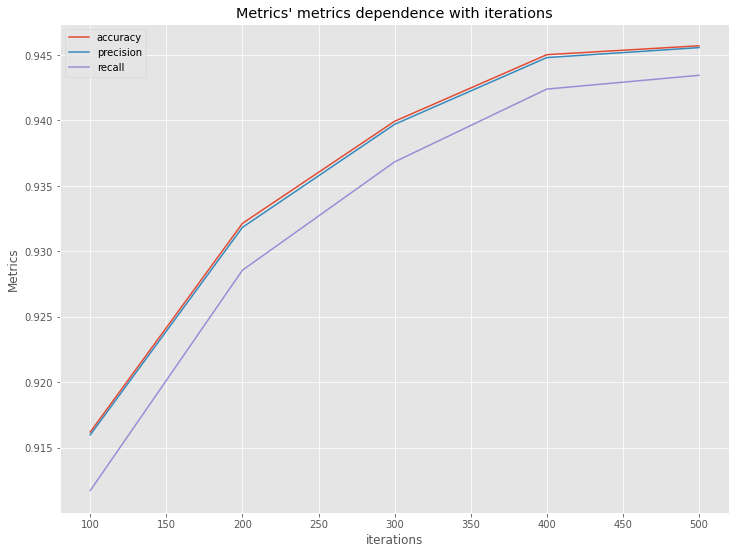

In [23]:
plot_complexity_metrics(
    model_cls=CatBoostClassifier,
    model_params=copy(extract_params(catboost_best_estimator)),
    grid_model_params=('iterations', np.arange(100, 600, 100)),
    n_jobs=None
)

400 `iterations` are enough

---

Conclusion: basic algorithms show sometimes better results than ensembles.

### Part 2. Blending the models

Take three (or more) best models and try to build the blending ensemble of them. Compare the quality of the final model using the same quality measures as above.

According to the experiments above, the most appropriate accuracy have `LogisticRegression`, `Catboost` and `SVM` with `linear` and `rbf` kernels. `Catboost` runs much more time spent compared to `LogisticRegression` showing the same accuracy. So, let's choose them for stacking.

In [24]:
class ModelsStackngClassifier(BaseEstimator, ClassifierMixin):
    def __init__(
        self,
        meta_model: Pipeline,
        base_estimators: List[Pipeline],
        test_size: float=0.5,
        max_shuffles: int=7,
    ):
        self.meta_model = meta_model
        self.base_estimators = base_estimators
        self.test_size = test_size
        self.max_shuffles = max_shuffles
    
    def bootstrap_fit_(self, X_train, y_train):
        X_base, X_meta, y_base, y_meta = \
            train_test_split(
                X_train, 
                y_train, 
                test_size=self.test_size, 
                stratify=y_train,
                random_state=23)
        models, probas = [], []
        for estimator in self.base_estimators:
            model = clone(estimator).fit(X_base, y_base)
            probas.append(model.predict_proba(X_meta))
            models.append(model)
        X_transformed = np.hstack(probas)
        return X_transformed, y_meta, models
    
    def fit(self, X_train, y_train):
        self.meta_models, self.models = [], []
        for _ in range(self.max_shuffles):
            X_transformed, y_meta, models = self.bootstrap_fit_(X_train, y_train)
            meta_clone = clone(meta_model).fit(X_transformed, y_meta)
            self.meta_models.append(meta_clone)
            self.models.append(models)
        return self
    
    def extract_most_common_(self, y_predicted):
        return sps.mode(
            np.hstack(y_predicted).reshape(-1, self.max_shuffles), 
            axis=1).mode[:, 0]
    
    def predict(self, X_test):
        y_predicted = []
        for i in range(self.max_shuffles):
            X_transformed = np.hstack([
                model.predict_proba(X_test)
                for model in self.models[i]
            ])
            y_predicted.append(
                self.meta_models[i]\
                    .predict(X_transformed)\
                    .reshape(-1, 1))
        return self.extract_most_common_(y_predicted)

In [25]:
lr_best_estimator

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='saga', tol=0.01, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [26]:
svm_linear_best_estimator

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 SVC(C=0.01, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='linear', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [27]:
svm_rbf_best_estimator

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 SVC(C=10, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [28]:
meta_model = Pipeline([
    ('sc', StandardScaler()),
    ('clf', LogisticRegression(
        C=100,
        max_iter=10**3,
        solver='saga',
        tol=1e-2,
        multi_class='multinomial',
        penalty='l2'
    ))
])

base_estimators = [
    clone(lr_best_estimator),
    clone(svm_linear_best_estimator),
    clone(svm_rbf_best_estimator),
]

In [29]:
%%time
stacking_model = ModelsStackngClassifier(
    meta_model=meta_model,
    base_estimators=base_estimators,
    max_shuffles=10,
).fit(X_train_pca, y_train)

CPU times: user 5min 57s, sys: 2.38 s, total: 5min 59s
Wall time: 5min 58s


In [30]:
y_predicted = stacking_model.predict(X_test_pca)
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       496
         1.0       0.98      0.92      0.95       471
         2.0       1.00      0.96      0.98       420
         3.0       0.96      0.88      0.92       491
         4.0       0.90      0.97      0.94       532
         5.0       1.00      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



Conclusion: our stacked model has the same accuracy as base estimators. Possibly, we can make it better for 1-2% by finding more appropriate hyperparameters, etc.

### Part 3. Explaining the model and estimating the feature importances.

Now your goal to take three best models and estimate feature importances using this models.

* First, use the methods that libraries provide by default (e.g. `lightgbm.plot_importance`).
* Next, use the [`shap`](https://github.com/slundberg/shap) library to explain the models behaviour and analyse the model performance. Compare the feature importances estimated by `shap` and by methods on the previous step.

In [31]:
try:
    import lightgbm as lgb
except ModuleNotFoundError:
    !pip3 install lightgbm
    import lightgbm as lgb

According to the official documentation, `lightgbm.plot_importance` uses `lightgbm.Booster` and `lightgbm.LGBMModel`. None of them showed top3 best results. Basic models set good enough baseline. Now, I suggest using `lightgbm.LGBMClassifier` with different parameters instead of three best models.

In [32]:
lgb_params = [
    {
        "learning_rate": 0.5,
        "max_depth": 6,
        "num_leaves": 4,
        "n_estimators": 120,
    },
    {
        "learning_rate": 0.9,
        "max_depth": 4,
        "num_leaves": 6,
        "n_estimators": 100,
    },
    {
        "learning_rate": 1,
        "max_depth": 3,
        "num_leaves": 6,
        "n_estimators": 80,
    }
]

In [33]:
lgb_models = [
    lgb.LGBMClassifier(**params).fit(X_train_pca, y_train)
    for params in lgb_params
]

In [34]:
plt.style.use('fast')

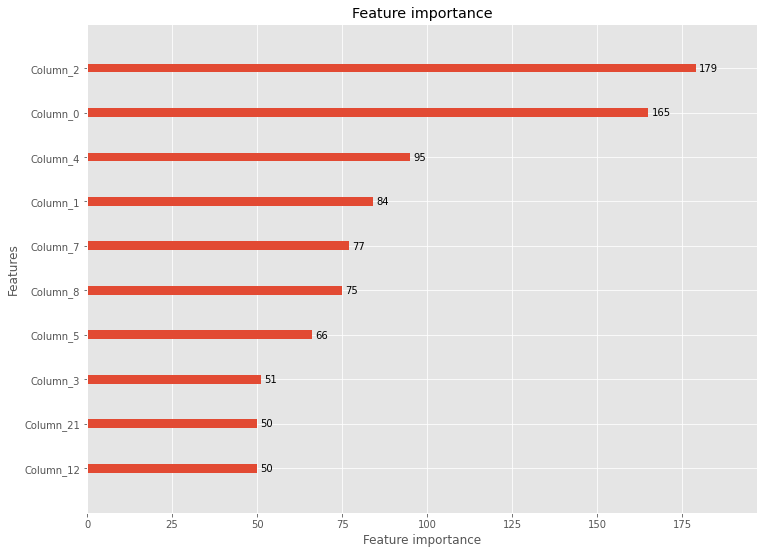

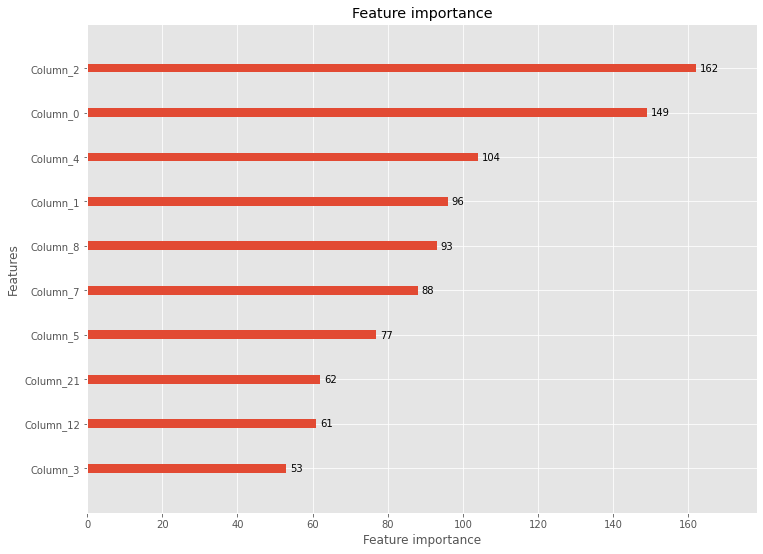

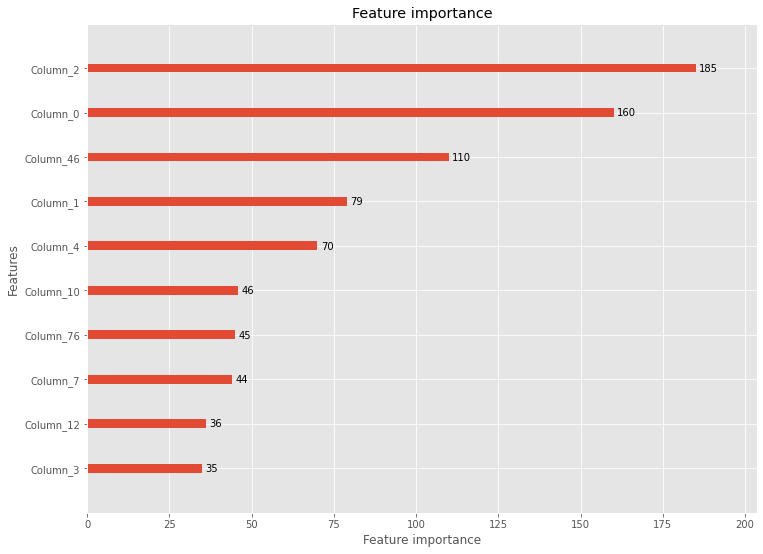

In [35]:
for i, lgb_model in enumerate(lgb_models):
    lgb.plot_importance(
        lgb_model, 
        figsize=(12, 9),
        max_num_features=10
    )

Feature importance shows that features `#0`, `#1`, `#2`, `#4` are in top-5.

/home/mvcibuntu/.local/lib/python3.7/site-packages/shap/explainers/tree.py:114: UserWarning:

Setting feature_perturbation = "tree_path_dependent" because no background data was given.



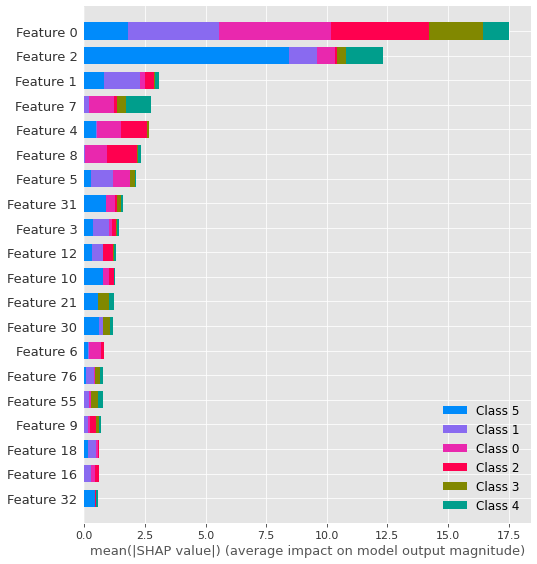

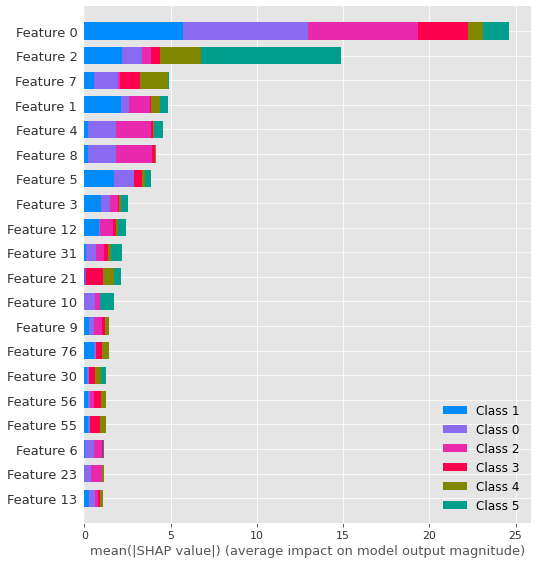

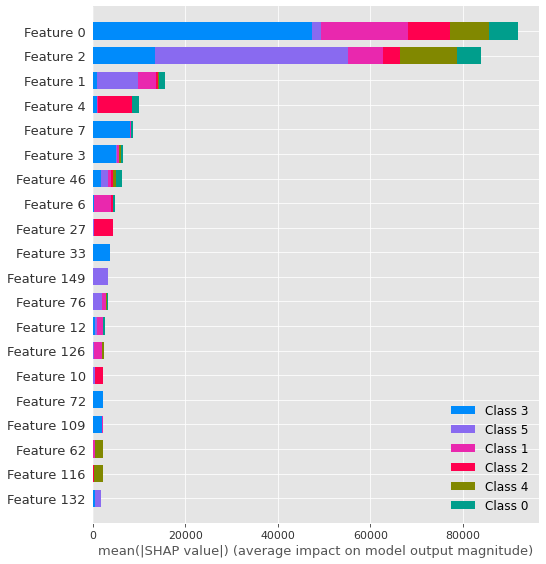

In [36]:
shap.initjs()

for lgb_model in lgb_models:
    shap.summary_plot(
        shap.TreeExplainer(
            lgb_model,
            feature_perturbation='interventional'
        ).shap_values(X_train_pca), 
        X_train_pca)

Feature importance shows that features `#0`, `#1`, `#2`, `#4`, `#7` are in top-5.

---

Conclusion: shap-values is a much more intuitive way to look at the significance of attributes than the built-in `feature_importance`; there is an opportunity to see the features that are most significant for each of the classes.